<a href="https://colab.research.google.com/github/cfcastillo/DS-6-Notebooks/blob/main/Project_5_Notebook_cfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition
The goal of this project is to demonstrate the ability to pull data from an SQL database and to perform exploratory data analysis on that data. Here is [a link to the project details](https://docs.google.com/document/d/1Eoq5MdMySlKZr70NJCwdi4a9iIw91oLWtQI-Nmb9dSQ/edit).


1. Pick one or more datasets from the Open Data Sets available from Google BigQuery.
1. Come up with questions about your data.
1. Use SQL queries to pull the specific information for your questions. *Note: data manipulation must be done using SQL, not DataFrames.*
1. Make some plots. Plot data should be filtered using SQL before plotting.
1. Present findings along with plots to the class.


# Project Process

I chose to look at the schemas through Big Query rather than in my notebook because it was easier to visualize the data there. I also built and tested my queries in Big Query before porting them here.

# Data Collection

## Choose Data

Here is a list of interesting datasets to explore:

- [Consumer Complaint Database](https://console.cloud.google.com/marketplace/product/cfpb/complaint-database?project=ds-6-project-5)
  - click "run sample" link to get to data.
  - single table
- [American Consumer Survey - maybe use for Capstone](https://console.cloud.google.com/marketplace/product/united-states-census-bureau/acs?project=ds-6-project-5)
  - Data summarized. 
- **DEFERRED** [Data 360 - Traffic Safety](https://console.cloud.google.com/marketplace/product/dataflix-public-datasets/data-360-traffic-and-safety?project=ds-6-project-5)
  - multiple tables; each has incident data
  - unique key
    - consecutive_number - which is the state code + case number
  - can join multiple events on unique key
- [US Forestry Industry Analysis](https://console.cloud.google.com/marketplace/product/us-forest-service/forest-inventory-analysis?project=ds-6-project-5)
  - has multiple tables so can demonstrate joins.
- [BEA GDP and Income Data - maybe use for Capstone](https://console.cloud.google.com/marketplace/product/bureau-econonmic-analysis/gdp-income-by-county?project=ds-6-project-5)
  - Data summarized
- **SELECTED** [Historical Air Quality](https://console.cloud.google.com/marketplace/product/epa/historical-air-quality?project=ds-6-project-5)
  - Different datasets for each type of measure like wind, temperature, pressure, particulate, etc.
  - Data is summarized
  - Unique key
    - state_code
    - county_code
    - site_num
- **SELECTED** [National Homelessness](https://console.cloud.google.com/marketplace/product/housing-urban-development/homelessness-count?project=ds-6-project-5)
  - single table
- [US Residential Real-Estate Stats](https://console.cloud.google.com/marketplace/product/housecanary-com/housecanary?project=ds-6-project-5)
  - need to pay for service to access.

## Imports

In [1]:
# grab the imports needed for the project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.cloud import bigquery
import re

# import seaborn as sns
# import statsmodels.api as sm

# # all
# from sklearn import datasets
# from sklearn import metrics
# from sklearn import preprocessing
# from sklearn.metrics import classification_report
# import sklearn.model_selection as model_selection
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV

# # Gaussian Naive Bayes
# from sklearn.naive_bayes import GaussianNB
# from sklearn.naive_bayes import MultinomialNB

# # Regression
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor 
# from sklearn.ensemble import RandomForestRegressor
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# from sklearn.metrics import accuracy_score
# from sklearn import metrics

## Load Data

[BigQuery Datasets](https://console.cloud.google.com/marketplace/browse?filter=solution-type:dataset&project=ds-6-project-5)

[BigQuery Project Link](https://console.cloud.google.com/bigquery?project=ds-6-project-5)

In [2]:
# Connect to BigQuery
project_id = 'ds-6-project-5'
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
# Set query limits to avoid incurring unexpected charges. Free limit is 1TB.
# Note that limit applies to querying.
ONE_MB = 1000*1000
ONE_GB = 1000*ONE_MB

In [4]:
# Create client object that will be used to query data
client = bigquery.Client(project=project_id)

# Where data is located in Big Query
project_name = 'bigquery-public-data'

# Homelessness Data

## Details

[National Homelessness](https://console.cloud.google.com/marketplace/product/housing-urban-development/homelessness-count?project=ds-6-project-5)
- single table

## Skills Used

- WITH statement to setup subquery
- UNION ALL to append multiple datasets together into a transformed result
- LEFT() to pull State code from a column
- WHERE clause with IS NOT NULL and AND
- GROUP BY with SUM() to summarize the data before transforming
- Stacked bar plot using groupby() and unstack()

## Extract Data

The data was not in a plot-friendly format. So I transformed the data from columns to rows with categories for easier plotting.

In [26]:
# Cache instance and table name(s) so can change in one place if needed and will propagate to queries.
hud_instance = 'sdoh_hud_pit_homelessness'
hud_table = 'hud_pit_by_coc'

In [27]:
# Construct a reference to the "covid19_google_mobility" dataset
# dataset_ref = client.dataset("covid19_geotab_mobility_impact", project="bigquery-public-data")
dataset_ref = client.dataset(hud_instance, project=project_name)

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Get all the tables in the dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset
for table in tables: 
  print(table.table_id)

hud_pit_by_coc


In [29]:
# Construct a reference to the "mobility report" table
table_ref = dataset.table(hud_table)

# API request - fetch the table
table = client.get_table(table_ref)

# See the table's schema - name, field type, mode, description
table.schema

[SchemaField('CoC_Number', 'STRING', 'NULLABLE', 'Number of the Continuum of Care Area', ()),
 SchemaField('CoC_Name', 'STRING', 'NULLABLE', 'Name of the Continuum of Care Area', ()),
 SchemaField('CoC_Category', 'STRING', 'NULLABLE', 'Only for 2018', ()),
 SchemaField('Overall_Homeless', 'INTEGER', 'NULLABLE', 'Total Homeless Population', ()),
 SchemaField('Sheltered_ES_Homeless', 'INTEGER', 'NULLABLE', 'Homeless in Emergency Shelters', ()),
 SchemaField('Sheltered_TH_Homeless', 'INTEGER', 'NULLABLE', 'Homeless in Transitional Housing', ()),
 SchemaField('Sheltered_SH_Homeless', 'INTEGER', 'NULLABLE', 'Homeless in Safe Haven Housing', ()),
 SchemaField('Sheltered_Total_Homeless', 'INTEGER', 'NULLABLE', 'Total Sheltered Homeless', ()),
 SchemaField('Unsheltered_Homeless', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('Homeless_Individuals', 'INTEGER', 'NULLABLE', 'Individuals not with Families', ()),
 SchemaField('Sheltered_ES_Homeless_Individuals', 'INTEGER', 'NULLABLE', 'Emergency S

## Data Dictionary


- Sheltered - Shelter Types
  - ES - Emergency shelter
  - TH - Transitional housing
  - SH - Safe haven housing
- Unsheltered
- Categories
  - Individuals
  - People in families
  - Family Households
  - Youth - various categories
  - Veterans
- Chronic - homeless for a year





In [28]:
# Look at data prior to data transformation
query = f'''
        SELECT *
        FROM {project_name}.{hud_instance}.{hud_table}
        LIMIT 5
'''
df = client.query(query).to_dataframe()
df.head()

,CoC_Number,CoC_Name,CoC_Category,Overall_Homeless,Sheltered_ES_Homeless,Sheltered_TH_Homeless,Sheltered_SH_Homeless,Sheltered_Total_Homeless,Unsheltered_Homeless,Homeless_Individuals,Sheltered_ES_Homeless_Individuals,Sheltered_TH_Homeless_Individuals,Sheltered_SH_Homeless_Individuals,Sheltered_Total_Homeless_Individuals,Unsheltered_Homeless_Individuals,Homeless_People_in_Families,Sheltered_ES_Homeless_People_in_Families,Sheltered_TH_Homeless_People_in_Families,Sheltered_Total_Homeless_People_in_Families,Unsheltered_Homeless_People_in_Families,Homeless_Family_Households,Sheltered_ES_Homeless_Family_Households,Sheltered_TH_Homeless_Family_Households,Sheltered_Total_Homeless_Family_Households,Unsheltered_Homeless_Family_Households,Chronically_Homeless,Sheltered_ES_Chronically_Homeless,Sheltered_SH_Chronically_Homeless,Sheltered_Total_Chronically_Homeless,Unsheltered_Chronically_Homeless,Chronically_Homeless_Individuals,Sheltered_ES_Chronically_Homeless_Individuals,Sheltered_SH_Chronically_Homeless_Individuals,Sheltered_Total_Chronically_Homeless_Individuals,Unsheltered_Chronically_Homeless_Individuals,Chronically_Homeless_People_in_Families,Sheltered_ES_Chronically_Homeless_People_in_Families,Sheltered_Total_Chronically_Homeless_People_in_Families,Unsheltered_Chronically_Homeless_People_in_Families,Homeless_Veterans,...,Unsheltered_Homeless_Veterans,Homeless_Unaccompanied_Youth_Under_25,Sheltered_ES_Homeless_Unaccompanied_Youth_Under_25,Sheltered_TH_Homeless_Unaccompanied_Youth_Under_25,Sheltered_SH_Homeless_Unaccompanied_Youth_Under_25,Sheltered_Total_Homeless_Unaccompanied_Youth_Under_25,Unsheltered_Homeless_Unaccompanied_Youth_Under_25,Homeless_Unaccompanied_Youth_Under_18,Sheltered_ES_Homeless_Unaccompanied_Youth_Under_18,Sheltered_TH_Homeless_Unaccompanied_Youth_Under_18,Sheltered_SH_Homeless_Unaccompanied_Youth_Under_18,Sheltered_Total_Homeless_Unaccompanied_Youth_Under_18,Unsheltered_Homeless_Unaccompanied_Youth_Under_18,Homeless_Unaccompanied_Youth_Age_18_24,Sheltered_ES_Homeless_Unaccompanied_Youth_Age_18_24,Sheltered_TH_Homeless_Unaccompanied_Youth_Age_18_24,Sheltered_SH_Homeless_Unaccompanied_Youth_Age_18_24,Sheltered_Total_Homeless_Unaccompanied_Youth_Age_18_24,Unsheltered_Homeless_Unaccompanied_Youth_Age_18_24,Homeless_Parenting_Youth_Under_25,Sheltered_ES_Homeless_Parenting_Youth_Under_25,Sheltered_TH_Homeless_Parenting_Youth_Under_25,Sheltered_Total_Homeless_Parenting_Youth_Under_25,Unsheltered_Homeless_Parenting_Youth_Under_25,Homeless_Parenting_Youth_Under_18,Sheltered_ES_Homeless_Parenting_Youth_Under_18,Sheltered_TH_Homeless_Parenting_Youth_Under_18,Sheltered_Total_Homeless_Parenting_Youth_Under_18,Unsheltered_Homeless_Parenting_Youth_Under_18,Homeless_Parenting_Youth_Age_18_24,Sheltered_ES_Homeless_Parenting_Youth_Age_18_24,Sheltered_TH_Homeless_Parenting_Youth_Age_18_24,Sheltered_Total_Homeless_Parenting_Youth_Age_18_24,Unsheltered_Homeless_Parenting_Youth_Age_18_24,Homeless_Children_of_Parenting_Youth,Sheltered_ES_Homeless_Children_of_Parenting_Youth,Sheltered_TH_Homeless_Children_of_Parenting_Youth,Sheltered_Total_Homeless_Children_of_Parenting_Youth,Unsheltered_Homeless_Children_of_Parenting_Youth,Count_Year
0,AK-500,Anchorage CoC,None,1023,665,305,0,970,53,736,530,158,0,688,48,287,135,147,282,5,102,52,48,100,2,101,59,0,59,42,94,56,0,56,38,7,3,3,4,138,...,18,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2014
1,AK-500,Anchorage CoC,None,1122,676,394,0,1070,52,844,553,239,0,792,52,278,123,155,278,0,87,38,49,87,0,89,68,0,68,21,83,62,0,62,21,6,6,6,0,144,...,6,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2013
2,AK-500,Anchorage CoC,None,1147,704,393,0,1097,50,791,561,195,0,756,35,356,143,198,341,15,126,41,81,122,4,114,109,0,10

In [28]:
# Here is an example of how to transform the data from columns into rows for easier plotting and querying.
# The table had the data pivoted into columns for each category which is good for performing arithmetic
#   on the data, but is not so good for plotting.
# Note: I only took a sample of the columns available.
# Use WITH to create a reusable subquery. Realistically, I would pull this into a dataframe and then 
# continue querying from there to avoid BigData charges.
subquery = f'''
WITH tdata AS (
--Individuals
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '1' as Sheltered, 
    'ES' as Shelter_Type, 'individual' as Category, SUM(Sheltered_ES_Homeless_Individuals) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Sheltered_ES_Homeless_Individuals IS NOT NULL AND Sheltered_ES_Homeless_Individuals <> 0) 
GROUP BY State, Count_Year
UNION ALL 
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '1' as Sheltered,
    'TH' as Shelter_Type, 'individual' as Category, SUM(Sheltered_TH_Homeless_Individuals) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Sheltered_TH_Homeless_Individuals IS NOT NULL AND Sheltered_TH_Homeless_Individuals <> 0) 
GROUP BY State, Count_Year
UNION ALL 
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '1' as Sheltered,
    'SH' as Shelter_Type, 'individual' as Category, SUM(Sheltered_SH_Homeless_Individuals) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Sheltered_SH_Homeless_Individuals IS NOT NULL AND Sheltered_SH_Homeless_Individuals <> 0) 
GROUP BY State, Count_Year
UNION ALL 
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '0' as Sheltered,
    'NA' as Shelter_Type, 'individual' as Category, SUM(Unsheltered_Homeless_Individuals) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Unsheltered_Homeless_Individuals IS NOT NULL AND Unsheltered_Homeless_Individuals <> 0) 
GROUP BY State, Count_Year
UNION ALL
--Families
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '1' as Sheltered,
    'ES' as Shelter_Type, 'family' as Category, SUM(Sheltered_ES_Homeless_People_in_Families) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Sheltered_ES_Homeless_People_in_Families IS NOT NULL AND Sheltered_ES_Homeless_People_in_Families <> 0) 
GROUP BY State, Count_Year
UNION ALL 
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '1' as Sheltered,
    'TH' as Shelter_Type, 'family' as Category, SUM(Sheltered_TH_Homeless_People_in_Families) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Sheltered_TH_Homeless_People_in_Families IS NOT NULL AND Sheltered_TH_Homeless_People_in_Families <> 0) 
GROUP BY State, Count_Year
UNION ALL 
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '0' as Sheltered, 
    'NA' as Shelter_Type, 'family' as Category, SUM(Unsheltered_Homeless_People_in_Families) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Unsheltered_Homeless_People_in_Families IS NOT NULL AND Unsheltered_Homeless_People_in_Families <> 0) 
GROUP BY State, Count_Year
UNION ALL 
--Veterans
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '1' as Sheltered,
    'ES' as Shelter_Type, 'veteran' as Category, SUM(Sheltered_ES_Homeless_Veterans) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Sheltered_ES_Homeless_Veterans IS NOT NULL AND Sheltered_ES_Homeless_Veterans <> 0) 
GROUP BY State, Count_Year
UNION ALL 
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '1' as Sheltered, 
    'TH' as Shelter_Type, 'veteran' as Category, SUM(Sheltered_TH_Homeless_Veterans) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Sheltered_TH_Homeless_Veterans IS NOT NULL AND Sheltered_TH_Homeless_Veterans <> 0) 
GROUP BY State, Count_Year
UNION ALL 
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '1' as Sheltered,
    'SH' as Shelter_Type, 'veteran' as Category, SUM(Sheltered_SH_Homeless_Veterans) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Sheltered_SH_Homeless_Veterans IS NOT NULL AND Sheltered_SH_Homeless_Veterans <> 0) 
GROUP BY State, Count_Year
UNION ALL 
SELECT LEFT(CoC_Number,2) AS State, Count_Year, '0' as Sheltered, 
    'NA' as Shelter_Type, 'veteran' as Category, SUM(Unsheltered_Homeless_Veterans) as How_Many 
FROM {project_name}.{hud_instance}.{hud_table}
WHERE (Unsheltered_Homeless_Veterans IS NOT NULL AND Unsheltered_Homeless_Veterans <> 0) 
GROUP BY State, Count_Year
)
'''

## Query Data

### Question 1: What is the category breakdown by year for homelessness?

In [29]:
# Now use sub query to query the data
query = subquery + f'''
SELECT SUM(How_Many) as how_many, Category, Count_Year as year
FROM tdata
GROUP BY Category, Count_Year
'''
df = client.query(query).to_dataframe()
df.head(50)

,how_many,Category,Count_Year
0,360189,individual,2014
1,368174,individual,2013
2,382156,individual,2012
3,372417,individual,2018
4,366585,individual,2017
5,355212,individual,2016
6,358422,individual,2015
7,49689,veteran,2014
8,40020,veteran,2017
9,39471,veteran,2016


#### Question 1: Plot Data

In [63]:
# Prepare data for plotting
df_to_plot = df.groupby(['Count_Year','Category'])['how_many'].sum().unstack()
df_to_plot

Category,family,individual,veteran
Count_Year,,,
2012,239397,382156,25436
2013,222190,368174,20710
2014,216261,360189,49689
2015,206286,358422,47725
2016,194716,355212,39471
2017,184411,366585,40020
2018,180413,372417,37878


In [ ]:
# Plot data using stacked barchart.
df_to_plot.plot.bar(stacked=True)
plt.legend(ncol=3, bbox_to_anchor=(.9,-.25))
plt.plot()

### Question 2: What are homelessness trends by State?

To make the plots more meaningful, take the top 10 states with the highest homelessness rates.

In [81]:
# Get base data
query = subquery + f'''
SELECT SUM(How_Many) as how_many, State, Count_Year as year
FROM tdata
WHERE State IN (SELECT State
                FROM tdata
                GROUP BY State
                ORDER BY SUM(How_Many) DESC
                LIMIT 10)
GROUP BY State, Count_Year
'''
df = client.query(query).to_dataframe()
# df.head(50)

df['State'].value_counts()

MA    7
PA    7
OR    7
WA    7
GA    7
TX    7
CA    7
NY    7
IL    7
FL    7
Name: State, dtype: int64

#### Question 2: Plot Data

In [68]:
# Prepare data for plotting
df_to_plot = df.groupby(['year','State'])['how_many'].sum().unstack()
df_to_plot

State,CA,FL,GA,IL,MA,NY,OR,PA,TX,WA
Count_Year,,,,,,,,,,
2012,130197,58300,21719,14478,17556,70157,16626,14871,36532,20882
2013,126561,51039,17876,13810,19078,77888,14607,15258,31486,18020
2014,126048,46094,17964,14341,22501,83132,13456,16744,31213,19875
2015,127049,39826,15338,14403,22268,90649,14690,16796,26071,20712
2016,127754,36461,13964,12539,20557,87600,14579,16475,24890,22311
2017,142968,35007,10886,11662,18418,90747,15204,15101,25748,23205
2018,140808,33573,10204,11447,21053,93121,15839,14494,27245,23940


[]

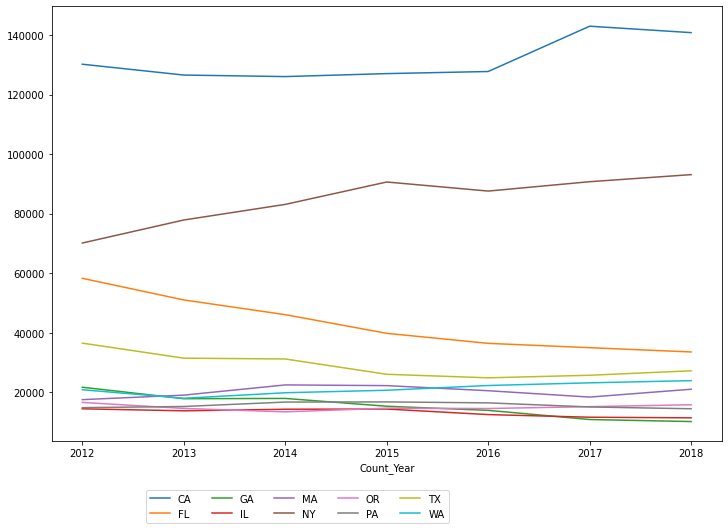

In [79]:
# TODO: Use interactive plot
# Plot data using stacked barchart.
df_to_plot.plot.line(figsize=(12,8))
plt.legend(ncol=5, bbox_to_anchor=(.6,-.1))
plt.plot()

# Historical Air Quality

## Details
[Historical Air Quality](https://console.cloud.google.com/marketplace/product/epa/historical-air-quality?project=ds-6-project-5)
- Different datasets for each type of measure like wind, temperature, pressure, particulate, etc.
- Data is summarized
- Unique key
  - state_code
  - county_code
  - site_num

## Skills Used

--TODO fill this out

## Extract Data

In [5]:
# Cache instance and table name(s) so can change in one place if needed and will propagate to queries.
air_instance = 'epa_historical_air_quality'


In [6]:
# Construct a reference to the "covid19_google_mobility" dataset
# dataset_ref = client.dataset("covid19_geotab_mobility_impact", project="bigquery-public-data")
dataset_ref = client.dataset(air_instance, project=project_name)

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Get all the tables in the dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset 
# After viewing full table list, I chose to select only the daily summaries because the hourly summaries 
# were too detailed.
for table in tables: 
  if re.search('.daily.', table.table_id):
    print(table.table_id)

co_daily_summary
hap_daily_summary
lead_daily_summary
no2_daily_summary
nonoxnoy_daily_summary
o3_daily_summary
pm10_daily_summary
pm25_frm_daily_summary
pm25_nonfrm_daily_summary
pm25_speciation_daily_summary
pressure_daily_summary
rh_and_dp_daily_summary
so2_daily_summary
temperature_daily_summary
voc_daily_summary
wind_daily_summary


In [16]:
# Look at schemas for the tables to confirm if they have the same columns.
for table in tables:
  if re.search('.daily.', table.table_id):
    table_details = client.get_table(table)
    print('-'*50)
    print(table_details.table_id)
    print('-'*50)
    print(table_details.schema)

--------------------------------------------------
co_daily_summary
--------------------------------------------------
[SchemaField('state_code', 'STRING', 'NULLABLE', 'The FIPS code of the state in which the monitor resides.', ()), SchemaField('county_code', 'STRING', 'NULLABLE', 'The FIPS code of the county in which the monitor resides.', ()), SchemaField('site_num', 'STRING', 'NULLABLE', 'A unique number within the county identifying the site.', ()), SchemaField('parameter_code', 'INTEGER', 'NULLABLE', 'The AQS code corresponding to the parameter measured by the monitor.', ()), SchemaField('poc', 'INTEGER', 'NULLABLE', 'This is the “Parameter Occurrence Code” used to distinguish different instruments that measure the same parameter at the same site.', ()), SchemaField('latitude', 'FLOAT', 'NULLABLE', 'The monitoring site’s angular distance north of the equator measured in decimal degrees.', ()), SchemaField('longitude', 'FLOAT', 'NULLABLE', 'The monitoring site’s angular distance ea

Confirmed that columns are the same for each table. This indicates that I can join the tables together on the same columns and summarize the data on the same columns and that I can easily UNION the results together from all tables into a single table for further analysis in a dataframe without having to hit the Big Query database. 

*Note: the data already comes in a summarized form. However the purpose of this exercise is to show that I can aggregate the detailed data so I will be doing the aggregation here using SQL.*

## Data Dictionary

[EPA Site describing air quality measures](https://www.epa.gov/naaqs)

### Air Quality

- CO - Carbon Monoxide
- HAP - Hazardous Air Pollutants - those pollutants that are known or suspected to cause cancer or other serious health effects. 
- Lead - 
- NO2 - Nitrogen Dioxide
- [NoNoxNoy](https://www.aeroqual.com/meet-the-nitrogen-oxide-family) - 
  - Nitric oxide (NO)
  - Oxides of nitrogen (NOx)
  - Reactive oxides of nitrogen (NOy)
- O3 - Ozone
- PM10 - Particulate Matter 10 micrometers and smaller - also known as course dust.
- PM25 - FRM Federal Reference Method vs. FEM Federal Equivalent Method
  - PM25 frm - PM 2.5 micrometers and smaller - fine dust.
  - PM25 nonfrm
  - pm25 speciation
- SO2 - Sulfer Dioxide
- VOC - [Volatile Organic Compounds](https://www.epa.gov/indoor-air-quality-iaq/volatile-organic-compounds-impact-indoor-air-quality)

### Weather

- RH and DP - Relative Humidity and Dewpoint
- Pressure
- Temperature
- Wind



## Query Data

### Question 1: What does the data look like?

I needed to see what the data looked like so that I could decide what questions to formulate based on the data storage and availability.

In [17]:
# Since there was a lot of data, I wanted to know what years were covered in the data
# and the number of records per datum.
query = f'''
  SELECT MIN(date_local) as earliest_date, MAX(date_local) as latest_date
  FROM {project_name}.{air_instance}.pm10_daily_summary
'''
df = client.query(query).to_dataframe()
df

,earliest_date,latest_date
0,1990-01-01,2019-12-31


Provided data is for years 1990 through 2019.

In [18]:
# Seeing what categories were included in nonoxnoy.
query = f'''
  SELECT DISTINCT parameter_name 
  FROM {project_name}.{air_instance}.nonoxnoy_daily_summary
'''
df = client.query(query).to_dataframe()
df

,parameter_name
0,Reactive oxides of nitrogen (NOy)
1,Nitric oxide (NO)
2,Oxides of nitrogen (NOx)


The results show what parameters are in the nonoxnoy prefixed tables.

In [25]:
# See how state code is stored. Get state code for New Mexico.
# Used wildcard to pick up anything that ended with Mexico.
# It was interesting to see that Mexico was in the data. hmmm. I thought this was only for the US.
query = f'''
  SELECT DISTINCT state_code, state_name, county_code, county_name, city_name  
  FROM {project_name}.{air_instance}.co_daily_summary
  WHERE state_name LIKE '%Mexico'
  ORDER BY state_code, county_code
  LIMIT 50
'''
df = client.query(query).to_dataframe()
df

,state_code,state_name,county_code,county_name,city_name
0,35,New Mexico,001,Bernalillo,Albuquerque
1,35,New Mexico,001,Bernalillo,North Valley
2,35,New Mexico,001,Bernalillo,South Valley
3,35,New Mexico,001,Bernalillo,Not in a city
4,35,New Mexico,013,Dona Ana,Las Cruces
5,35,New Mexico,013,Dona Ana,Not in a city
6,35,New Mexico,043,Sandoval,Not in a city
7,35,New Mexico,043,Sandoval,Rio Rancho Estates
8,35,New Mexico,045,San Juan,Farmington
9,35,New Mexico,049,Santa Fe,Santa Fe


We see that New Mexico is FIPS state code 35 which can be used for faster querying. We also see that the country of Mexico is included in the results. This was unexpected because I thought the data was only for the US. It looks like the Mexico data only contains cities that are US neighbors.

### Question 2: What data do I want to explore?

# Traffic Fatalities

May do this at some future date.

## Details

[Data 360 - Traffic Safety Data Source](https://console.cloud.google.com/marketplace/product/dataflix-public-datasets/data-360-traffic-and-safety?project=ds-6-project-5)
- multiple tables; each has incident data
- unique key
  - consecutive_number - which is the state code + case number
- can join multiple events on unique key

## Skills Used

--TODO fill this out

In [12]:
# Cache instance and table name(s) so can change in one place if needed and will propagate to queries.
traffic_instance = 'nhtsa_traffic_fatalities'
traffic_table = ''

In [26]:
# Construct a reference to the "covid19_google_mobility" dataset
# dataset_ref = client.dataset("covid19_geotab_mobility_impact", project="bigquery-public-data")
dataset_ref = client.dataset(traffic_instance, project=project_name)

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Get all the tables in the dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset 
# After viewing full table list, I chose to take 2016 because it was the most recent year available.
for table in tables: 
  if re.search('.2016', table.table_id):
    print(table.table_id)

accident_2016
cevent_2016
damage_2016
distract_2016
drimpair_2016
factor_2016
maneuver_2016
nmcrash_2016
nmimpair_2016
nmprior_2016
parkwork_2016
pbtype_2016
person_2016
safetyeq_2016
vehicle_2016
vevent_2016
vindecode_2016
violatn_2016
vision_2016
vsoe_2016
